# 1. Stroke prediction using Machine Learning

In this section we are going to predict if the patient will have a stroke or not. We will use Random Forest Classifier and KNN Classifier to predict the stroke. We will also use SMOTE to balance the data, since the "no-stroke" data is the majority class with a lot more data than the "stroke" data.

In [24]:
# import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df = pd.read_csv('./data/stroke-data-cleaned.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   ever_married                    5110 non-null   int64  
 4   avg_glucose_level               5110 non-null   float64
 5   bmi                             5110 non-null   float64
 6   stroke                          5110 non-null   int64  
 7   gender_female                   5110 non-null   int64  
 8   gender_male                     5110 non-null   int64  
 9   work_govt_job                   5110 non-null   int64  
 10  work_never_worked               5110 non-null   int64  
 11  work_private                    5110 non-null   int64  
 12  work_self_employed              51

# 1.1 Standardize, train, test split and SMOTE

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X = df.drop('stroke', axis=1)
y = df['stroke']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=4321)


# Perform standardization on the numerical features
scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.transform(X_test)

# Apply SMOTE on the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_stand, y_train)

In [28]:
original_counts = y_train.value_counts()
resampled_counts = y_train_smote.value_counts()

print('Original counts: ', original_counts, '\n', 'Resampled counts: ', resampled_counts)

Original counts:  stroke
0    3123
1     147
Name: count, dtype: int64 
 Resampled counts:  stroke
0    3123
1    3123
Name: count, dtype: int64


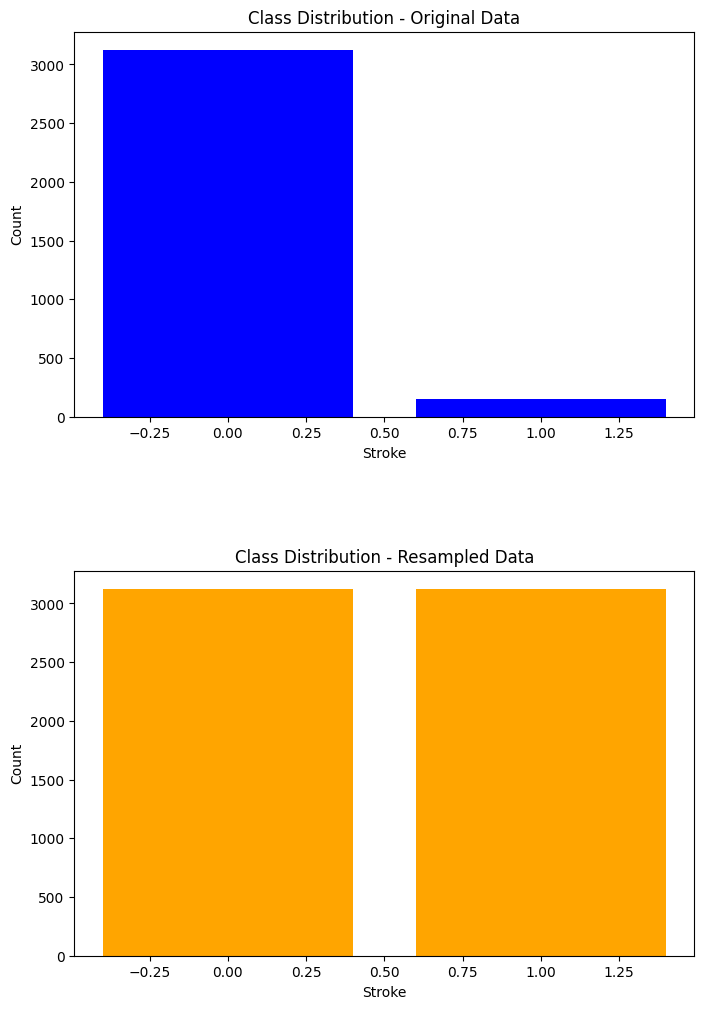

In [29]:
import matplotlib.pyplot as plt

original_counts = y_train.value_counts()
resampled_counts = y_train_smote.value_counts()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

ax1.bar(original_counts.index, original_counts.values, color='blue')
ax1.set_xlabel('Stroke')
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution - Original Data')

ax2.bar(resampled_counts.index, resampled_counts.values, color='orange')
ax2.set_xlabel('Stroke')
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution - Resampled Data')

plt.subplots_adjust(hspace=0.4)

plt.show()